In [2]:
import os
import pandas as pd
from datasets import Dataset, DatasetDict
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model
import json
import re

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Step 1: Load Dataset
dataset_path = '../.dataset/hdfs/train.csv'

/home/gabriel.talasso/log_ad_llm_fl/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv(dataset_path)#, nrows=10000)
data_normal = data[data["Label"] == 0]  # Filter out anomalies
data_anomaly = data[data["Label"] == 1] 

In [6]:
len(data_anomaly) / len(data_normal)

0.0303980505111137

In [14]:
(len(data_normal)*0.8 / 32 )* 5

55809.50000000001

In [8]:
33486*32/3

357184.0

In [3]:
regex = [
        r"(?<=blk_)[-\d]+", # block_id
        r'\d+\.\d+\.\d+\.\d+',  # IP
        r"(/[-\w]+)+",  # file path
        #r'(?<=[^A-Za-z0-9])(\-?\+?\d+)(?=[^A-Za-z0-9])|[0-9]+$',  # Numbers
        ]

def apply_regex(line):
    for r in regex:
        line = re.sub(r, '<*>', line)
    return line

In [4]:
data_normal['Content'] = data_normal['Content'].apply(apply_regex)

/tmp/ipykernel_2274797/148702825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_normal['Content'] = data_normal['Content'].apply(apply_regex)


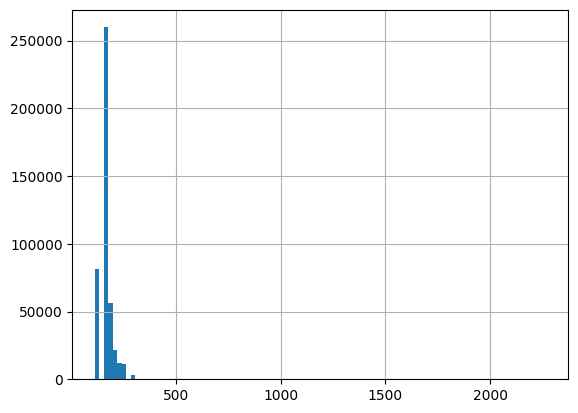

In [7]:

histogram = data_normal['Content'].apply(lambda x: len(x.split())).hist(bins=100)

Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors
/tmp/ipykernel_2274797/1782080245.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_normal['Content'] = data_normal['Content'].apply(lambda x: len(tokenizer(x)['input_ids']))


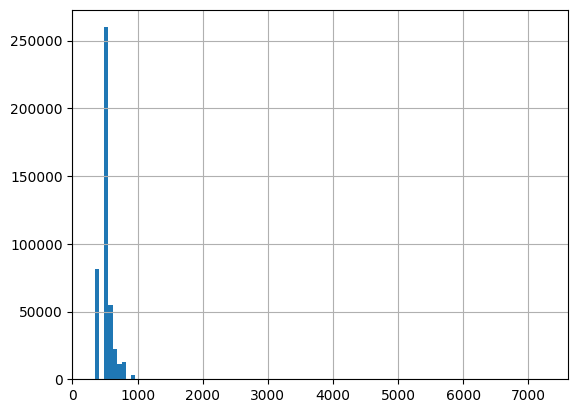

In [8]:
from transformers import AutoTokenizer

#len after tokenize

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
data_normal['Content'] = data_normal['Content'].apply(lambda x: len(tokenizer(x)['input_ids']))

histogram = data_normal['Content'].hist(bins=100)


In [16]:
#count len < 128
print(len(data_normal[data_normal['Content'] < 512]) / len(data_normal))

0.7195705928202187
